# ExternalSource operator

In this example, we will see how to use `ExternalSource` operator, that allows us to
use an external data source as an input to the Pipeline.

In order to achieve that, we have to define a Iterator or Generator class which `next` function will
return one or several `numpy` arrays.

In [1]:
import types
import collections
import numpy as np
from random import shuffle
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops            
import nvidia.dali.types as types

batch_size = 16

### Defining the iterator

In [2]:
class ExternalInputIterator(object):
    def __init__(self, batch_size):
        self.images_dir = "images/"
        self.batch_size = batch_size
        with open(self.images_dir + "file_list.txt", 'r') as f:
            self.files = [line.rstrip() for line in f if line is not '']
        shuffle(self.files)

    def __iter__(self):
        self.i = 0
        self.n = len(self.files)
        return self

    def __next__(self):
        batch = []
        for _ in range(self.batch_size):
            jpeg_filename, label = self.files[self.i].split(' ')
            f = open(self.images_dir + jpeg_filename)
            batch.append(np.frombuffer(f.read(), dtype = np.uint8))
            self.i = (self.i + 1) % self.n
        return batch
    
    next = __next__

### Defining the pipeline

The next step is to define the Pipeline.

We override `Pipeline.iter_setup`, a method called by the pipeline before every `Pipeline.run`, to call the iterator
and feed the result to `ExternalSource()` operator, referenced by `self.jpeg`, by using `feed_input`.

In [3]:
eii = ExternalInputIterator(batch_size)
iterator = iter(eii)

In [4]:
 class ExternalSourcePipeline(Pipeline):                                                                
    def __init__(self, batch_size, num_threads, device_id):
        super(ExternalSourcePipeline, self).__init__(batch_size,
                                      num_threads,
                                      device_id,
                                      seed=12)
        self.input = ops.ExternalSource()                                                  
        self.decode = ops.nvJPEGDecoder(device = "mixed", output_type = types.RGB)                                                      
        self.cast = ops.Cast(device = "gpu",                                                      
                             dtype = types.INT32) 

    def define_graph(self):                                                                
        self.jpegs = self.input()                                                          
        images = self.decode(self.jpegs)                                                   
        output = self.cast(images)
        return output                                                                      

    def iter_setup(self):                                                                  
        self.feed_input(self.jpegs, iterator.next())

### Using the pipeline

In [5]:
pipe = ExternalSourcePipeline(batch_size=batch_size, num_threads=2, device_id = 0)   
pipe.build()                                                                
pipe_out = pipe.run()      

In [6]:
batch_cpu = pipe_out[0].asCPU()

(427, 640, 3)


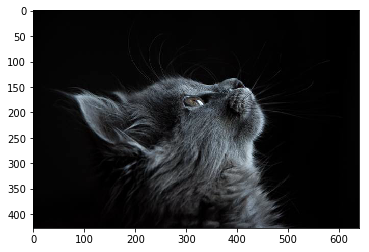

In [8]:
import matplotlib.pyplot as plt
img = batch_cpu.at(2)
print(img.shape)
plt.imshow(img.astype('uint8'))